In [1]:
import sys, os
# # add ../ to sys.path
# sys.path.append('../')

# change current directory
os.chdir('../')

# set CUDA_VISIBLE_DEVICES
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

# show images
from IPython.display import display
import PIL.Image as Image
import torch

# restrict cuda memory usage for this notebook
torch.cuda.empty_cache()
# torch.cuda.set_per_process_memory_fraction(0.75, 0)

from torch.nn import functional as F

def maskpooling(mask, res):
    '''
    Mask pooling to reduce the resolution of mask
    Input:
    mask: [B, 1, H, W]
    res: resolution
    Output: [B, 1, res, res]
    '''
    # mask[mask < 1] = 0
    mask[mask >0] = 1
    mask = -1 * mask
    kernel_size = mask.shape[2] // res
    mask = F.max_pool2d(mask, kernel_size=kernel_size, stride=kernel_size, padding=0)
    mask = -1*mask
    return mask

def compute_correspondence_matrix(source_feature, ref_feature):
    """
    Compute correspondence matrix between source and reference features.
    Args:
        source_feature: [B, C, H, W]
        ref_feature: [B, C, H, W]
    Returns:
        correspondence_matrix: [B, H*W, H*W]
    """
    # [B, C, H, W] -> [B, H, W, C]
    source_feature = source_feature.permute(0, 2, 3, 1)
    ref_feature = ref_feature.permute(0, 2, 3, 1)
    
    # [B, H, W, C] -> [B, H*W, C]
    source_feature = torch.reshape(source_feature, [source_feature.shape[0], -1, source_feature.shape[-1]])
    ref_feature = torch.reshape(ref_feature, [ref_feature.shape[0], -1, ref_feature.shape[-1]])
    
    # norm
    source_feature = F.normalize(source_feature, p=2, dim=-1)
    ref_feature = F.normalize(ref_feature, p=2, dim=-1)
    
    # cosine similarity
    cos_sim = torch.matmul(source_feature, ref_feature.transpose(1, 2)) # [B, H*W, H*W]
    
    return cos_sim

def display_tensor(image, type='rgb'):
    if image.dim() == 4:
        image = image.squeeze(0)
    image = image.permute(1, 2, 0)
    if type == 'rgb':
        
        # image = image * torch.tensor([0.229, 0.224, 0.225], device = image.device) + \
        #     torch.tensor([0.485, 0.456, 0.406], device = image.device)
        image = image * torch.tensor([0.5,0.5,0.5], device = image.device) + \
            torch.tensor([0.5,0.5,0.5], device = image.device)
        # clip to [0, 1]
        image = torch.clamp(image, 0, 1)
    elif type == 'gray':
        # rerange to [0, 1]
        image = image - image.min()
        image = image / image.max()
        # repeat 3 channels
        image = image.repeat(1,1,3)
        
    image = image.cpu().numpy()*255
    image = image.astype('uint8')
    # resize to 512x512
    image = Image.fromarray(image).resize((512, 512), resample=0)
    display(image)

def Dataloader_by_Index(data_loader, target=0):
    for index, data in enumerate(data_loader):
        if index == target:
            return data
    return None

/home/guohe/anaconda3/envs/icm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from icm.models.feature_extractor.modeling.meta_arch.ldm import LatentDiffusion
from icm.util import instantiate_feature_extractor, instantiate_from_config
from omegaconf import OmegaConf
# import dataloader
from torch.utils.data import DataLoader
from icm.src.models.dift_sd import SDFeaturizer

# init sd
# ldm = LatentDiffusion(init_checkpoint='sd://v2-1-base').cuda()

# init feature extractor
cfg = OmegaConf.load('config/region_matcher.yaml')
# feature_extractor = instantiate_feature_extractor(cfg.cfg_feature_extractor).cuda()
# feature_extractor.reset_dim_stride()
sd_model = 'pretrained_models/stable-diffusion-2-1'
feature_extractor = SDFeaturizer(sd_id=sd_model)
# init dataloader
dataset = instantiate_from_config(cfg.cfg_dataset)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)

IMAGE_SIZE = cfg.cfg_dataset.params.crop_size



load data using dataloader or manually

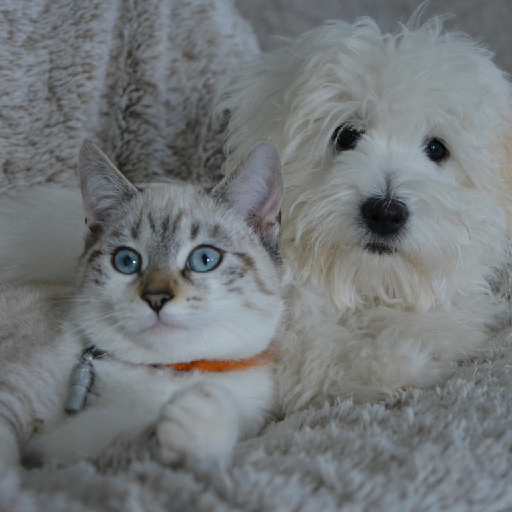

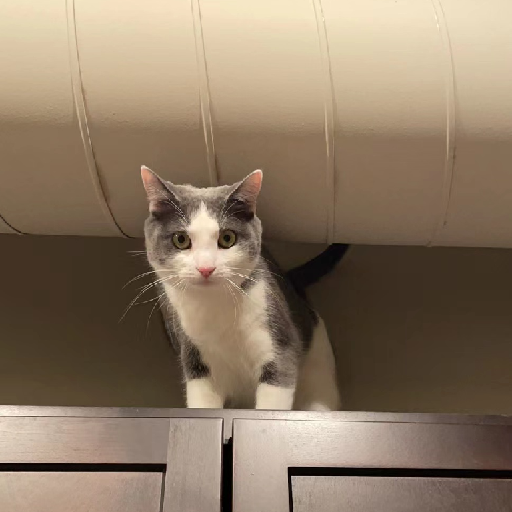

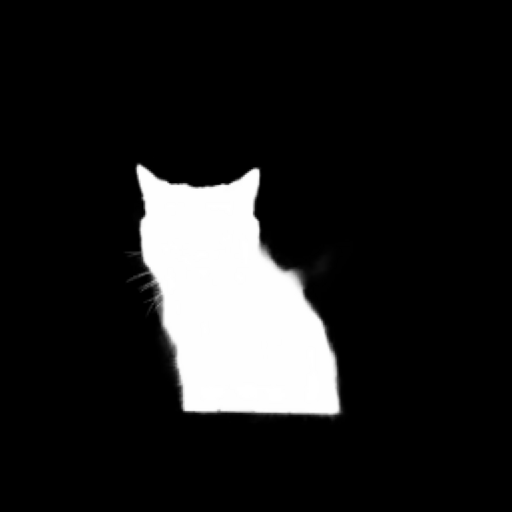

In [52]:

image_dir = '/data1/guohe/diffusion-matting/ICM/datasets/example_cats/image'
mask_dir = '/data1/guohe/diffusion-matting/ICM/datasets/example_cats/mask'

img_list = os.listdir(image_dir)
mask_list = os.listdir(mask_dir)

index = [1,0]

image, label = dataset.get_sample_example(image_dir, mask_dir, img_list, mask_list, index[0])

context_image, context_guidance = dataset.get_sample_example(image_dir, mask_dir, img_list, mask_list, index[1])

image = image.cuda().unsqueeze(0)
label = label.cuda().unsqueeze(0)


context_image = context_image.cuda().unsqueeze(0)
context_guidance = context_guidance.cuda().unsqueeze(0)
display_tensor(image, type='rgb')
display_tensor(context_image, type='rgb')
display_tensor(context_guidance, type='gray')

In [ ]:
# # get data
# data = Dataloader_by_Index(dataloader, target=5)
# image, label, trimap, image_name = data['image'], data['alpha'], data['trimap'], data['image_name']
# context_image, context_guidance = data['context_image'], data['context_guidance']

# image = image.cuda()
# label = label.cuda()
# trimap = trimap.cuda()

# context_image = context_image.cuda()
# context_guidance = context_guidance.cuda()

# display_tensor(image, type='rgb')
# display_tensor(context_image, type='rgb')
# display_tensor(context_guidance, type='gray')


importance

time_step > repeat > norm_type > prompt

In [53]:

import gc


from torchvision.transforms import PILToTensor

index=1
ensemble_size = 8
t=261
prompt = ''


gc.collect()

# forward
torch.cuda.empty_cache()

features = feature_extractor.forward(image, prompt=prompt,ensemble_size=ensemble_size,t=t,up_ft_index=index) # 1,960,32,32
# mean
gc.collect()
torch.cuda.empty_cache()


features_ref = feature_extractor.forward(context_image, prompt=prompt,ensemble_size=ensemble_size,t=t,up_ft_index=index)
gc.collect()
torch.cuda.empty_cache()


print(features.shape)
print(context_guidance.shape)

torch.Size([1, 1280, 48, 48])
torch.Size([1, 1, 768, 768])


In [ ]:
import torch


def unravel_index(index, shape):
    out = []
    for dim in reversed(shape):
        out.append(index % dim)
        index = index // dim
    return tuple(reversed(out))

def find_mask_in_target_bi(similarity_matrix, mask_ref):
    # Initialize mask for target image.
    h, w = mask_ref.shape
    mask_target = torch.zeros((h, w), dtype=torch.bool)

    # For each point in reference mask:
    for y, x in zip(*torch.where(mask_ref)):
        ref_index = y * w + x

        # Find the most similar point in the target image.
        target_index = similarity_matrix[:, ref_index].argmax()
        target_y, target_x = unravel_index(target_index, (h, w))
        
        # Check if the most similar point in reference image for the chosen target point is inside the mask.
        ref_most_similar_index = similarity_matrix[target_index, :].argmax()
        ref_most_similar_y, ref_most_similar_x = unravel_index(ref_most_similar_index, (h, w))
        
        if mask_ref[ref_most_similar_y, ref_most_similar_x]:
            mask_target[target_y, target_x] = True

    return mask_target.long()


def find_mask_in_target_r2t(similarity_matrix, mask_ref):
    # similarity_matrix: [height * width, height * width]
    # mask_ref: [height, width]
    
    h, w = mask_ref.shape
    # mask_target: [height, width]
    mask_target = torch.zeros((h, w), dtype=torch.bool)

    # For each point in reference mask:
    for y, x in zip(*torch.where(mask_ref)):
        # Find the most similar point in the target image.
        target_y, target_x = unravel_index(similarity_matrix[:, y*w + x].argmax(), (h, w))
        mask_target[target_y, target_x] = True

    return mask_target.long()

def find_mask_in_target_t2r(similarity_matrix, mask_ref):
    # similarity_matrix: [height * width, height * width]
    # mask_ref: [height, width]
    
    h, w = mask_ref.shape
    # mask_target: [height, width]
    mask_target = torch.zeros((h, w), dtype=torch.bool)

    # For each point in target image:
    for y in range(h):
        for x in range(w):
            # Find the most similar point in the reference image.
            ref_most_similar_y, ref_most_similar_x = unravel_index(similarity_matrix[y*w + x].argmax(), (h, w))
            
            # Check if the most similar point in reference image is inside the mask.
            if mask_ref[ref_most_similar_y, ref_most_similar_x]:
                mask_target[y, x] = True

    return mask_target.long()

In [ ]:
# # save memory
# def compute_similarity(feature, features_ref):
#     # feature: [feature_dim]
#     # features_ref: [height * width, feature_dim]

#     # Normalize the feature vectors
#     feature = feature / (torch.norm(feature) + 1e-8)
#     features_ref = features_ref / (torch.norm(features_ref, dim=-1, keepdim=True) + 1e-8)
    
#     # Compute cosine similarity for the feature with all features in features_ref.
#     similarity = torch.mv(features_ref, feature)
#     return similarity

# def find_mask_in_target_bi(features, features_ref, mask_ref):
#     h, w = mask_ref.shape
#     mask_target = torch.zeros((h, w), dtype=torch.bool)

#     for y, x in zip(*torch.where(mask_ref)):
#         ref_feature = features_ref[y * w + x]
#         similarity_to_target = compute_similarity(ref_feature, features)

#         target_y, target_x = unravel_index(similarity_to_target.argmax(), (h, w))
        
#         target_feature = features[target_y * w + target_x]
#         similarity_to_ref = compute_similarity(target_feature, features_ref)

#         ref_most_similar_y, ref_most_similar_x = unravel_index(similarity_to_ref.argmax(), (h, w))
        
#         if mask_ref[ref_most_similar_y, ref_most_similar_x]:
#             mask_target[target_y, target_x] = True

#     return mask_target.long()

# def find_mask_in_target_r2t(features, features_ref, mask_ref):
#     h, w = mask_ref.shape
#     mask_target = torch.zeros((h, w), dtype=torch.bool)

#     for y, x in zip(*torch.where(mask_ref)):
#         ref_feature = features_ref[y * w + x]
#         similarity_to_target = compute_similarity(ref_feature, features)

#         target_y, target_x = unravel_index(similarity_to_target.argmax(), (h, w))
#         mask_target[target_y, target_x] = True

#     return mask_target.long()

# def find_mask_in_target_t2r(features, features_ref, mask_ref):
#     h, w = mask_ref.shape
#     mask_target = torch.zeros((h, w), dtype=torch.bool)

#     for y in range(h):
#         for x in range(w):
#             target_feature = features[y * w + x]
#             similarity_to_ref = compute_similarity(target_feature, features_ref)

#             ref_most_similar_y, ref_most_similar_x = unravel_index(similarity_to_ref.argmax(), (h, w))
            
#             if mask_ref[ref_most_similar_y, ref_most_similar_x]:
#                 mask_target[y, x] = True

#     return mask_target.long()

In [ ]:
# bilinear upsampling to IMAGE_SIZE
COR_SIZE = (IMAGE_SIZE//4, IMAGE_SIZE//4)
features = F.interpolate(features, size=COR_SIZE, mode='bilinear', align_corners=False)
features_ref = F.interpolate(features_ref, size=COR_SIZE, mode='bilinear', align_corners=False)

# deep copy features
# features = features_ref.clone().detach()
cos_sim = compute_correspondence_matrix(features, features_ref).squeeze()
torch.cuda.empty_cache()
mask_ref = maskpooling(context_guidance, COR_SIZE[0]).squeeze()
# mask_ref = context_guidance.squeeze()
# features_ = features.reshape(features.shape[1], -1).transpose(0,1) # 32*32, 960
# features_ref_ = features_ref.reshape(features_ref.shape[1], -1).transpose(0,1) # 32*32, 960

# new_index = find_mask_in_target_bi(cos_sim, mask_ref).unsqueeze(0).unsqueeze(0) # 1*1*32*32
# new_index = find_mask_in_target_t2r(cos_sim, mask_ref).unsqueeze(0).unsqueeze(0) # 1*1*32*32
new_index= find_mask_in_target_r2t(cos_sim, mask_ref).unsqueeze(0).unsqueeze(0) # 1*1*32*32


display_tensor(new_index, type='gray')

# resize mask_result to 512*512
mask_result = new_index
mask_result = F.interpolate(mask_result.float(), size=(IMAGE_SIZE,IMAGE_SIZE), mode='nearest').to(image.device)
display_tensor(mask_result*image)

In [40]:
import torch.nn as nn
from torch import einsum
class TrainingFreeAttention:
    def __init__(self, res_ratio = 4, pool_type = 'average', temp_softmax = 1, use_scale = False,upsample_mode='bilinear') -> None:
        self.res_ratio = res_ratio
        self.pool_type = pool_type
        self.temp_softmax = temp_softmax
        self.use_scale = use_scale
        self.upsample_mode = upsample_mode
    def __call__(self, features, features_ref, roi_mask,):
        # roi_mask: [B, 1, H, W]
        # features: [B, C, h, w]
        # features_ref: [B, C, h, w]
        B, _, H, W = roi_mask.shape
        H_attn, W_attn = H//self.res_ratio, W//self.res_ratio
        features, features_ref = self.resize_input_to_res(features, features_ref, (H, W)) # [H//res_ratio, W//res_ratio]
        
        features_ref = self.get_roi_features(features_ref, roi_mask) # List, len = B, each element: [C_q, dim], dim = H//res_ratio * W//res_ratio
        
        features = features.reshape(B, -1, features.shape[2]* features.shape[3]).permute(0, 2, 1) # [B, C, dim]
        attn_output = self.compute_attention(features, features_ref) # List, len = B, each element: [C_q, C]
        
        attn_output = self.reshape_attn_output(attn_output, (H_attn, W_attn)) # List, len = B, each element: [C_q, H_attn, W_attn]
        
        return attn_output
    
    def resize_input_to_res(self, features, features_ref, size):
        # features: [B, C, h, w]
        # features_ref: [B, C, h, w]
        H, W = size
        target_H, target_W = H//self.res_ratio, W//self.res_ratio
        features = F.interpolate(features, size=(target_H, target_W), mode=self.upsample_mode)
        features_ref = F.interpolate(features_ref, size=(target_H, target_W), mode=self.upsample_mode)
        return features, features_ref

    def get_roi_features(self, feature, mask):
        '''
        get feature tokens by maskpool
        feature: [B, C, h, w]
        mask: [B, 1, H, W]  [0,1]
        return: List, len = B, each element: [token_num, C]
        '''
        
        # assert mask only has elements 0 and 1
        assert torch.all(torch.logical_or(mask==0, mask==1))
        assert mask.max() == 1 and mask.min() == 0
        
        B, _, H, W = mask.shape
        h, w = feature.shape[2:]
        
        output = []
        for i in range(B):
            mask_ = mask[i]
            feature_ = feature[i]
            feature_ = self.maskpool(feature_, mask_)
            output.append(feature_)
        return output
    
    def maskpool(self, feature, mask):
        '''
        get feature tokens by maskpool
        feature: [C, h, w]
        mask: [1, H, W]  [0,1]
        return: [token_num, C]
        '''
        
        if self.pool_type == 'max':
            mask = F.max_pool2d(mask, kernel_size = self.res_ratio, stride = self.res_ratio, padding = 0)
        elif self.pool_type == 'average':
            mask = F.avg_pool2d(mask, kernel_size = self.res_ratio, stride = self.res_ratio, padding = 0)
        elif self.pool_type == 'min':
            mask = -1*mask
            mask = F.max_pool2d(mask, kernel_size = self.res_ratio, stride = self.res_ratio, padding = 0)
            mask = -1*mask
        else:
            raise NotImplementedError
        
        # element-wise multiplication mask and feature
        feature = feature * mask
        
        index = (mask > 0).reshape(1, -1).squeeze()
        feature = feature.reshape(feature.shape[0], -1).permute(1, 0)
        
        feature = feature[index]
        return feature

    def compute_attention(self, features, features_ref):
        '''
        features: [B, C, dim]
        features_ref: List, len = B, each element: [C_q, dim]
        return: List, len = B, each element: [C_q, C]
        '''
        output = []
        for i in range(len(features_ref)):
            feature_ref = features_ref[i]
            feature = features[i]
            feature = self.compute_attention_single(feature, feature_ref)
            output.append(feature)
        return output
    
    def compute_attention_single(self, feature, feature_ref):
        '''
        compute attention with softmax
        feature: [C, dim]
        feature_ref: [C_q, dim]
        return: [C_q, C]
        '''
        scale = feature.shape[-1]**-0.5 if self.use_scale else 1.0
        sim = einsum('i d, j d -> i j', feature_ref, feature)*scale
        sim = sim/self.temp_softmax
        sim = sim.softmax(dim=-1)
        return sim
    
    def reshape_attn_output(self, attn_output, attn_size):
        '''
        attn_output: List, len = B, each element: [C_q, C]
        return: List, len = B, each element: [C_q, H_attn, W_attn]
        '''
        # attn_output[0].shape[1] sqrt to get H_attn, W_attn
        H_attn, W_attn = attn_size
        
        output = []
        for i in range(len(attn_output)):
            attn_output_ = attn_output[i]
            attn_output_ = attn_output_.reshape(attn_output_.shape[0], H_attn, W_attn)
            output.append(attn_output_)
        return output

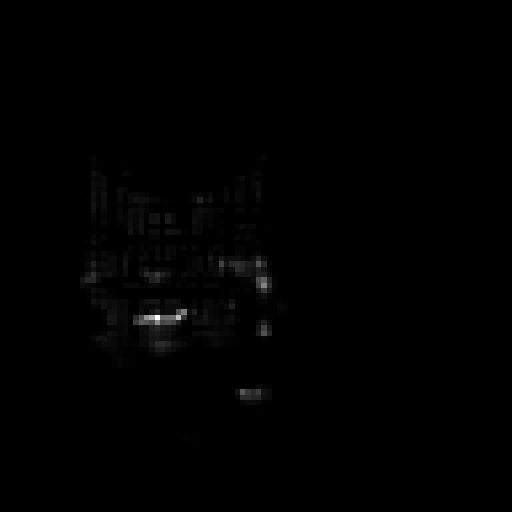

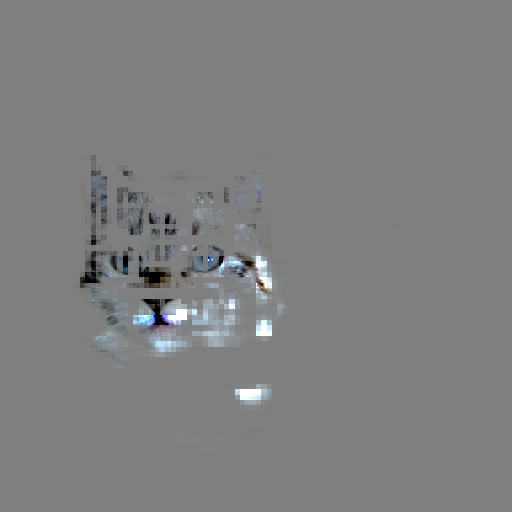

0


In [60]:
attn_module = TrainingFreeAttention(res_ratio = 8, pool_type = 'min', temp_softmax = 1000, use_scale = False,upsample_mode='bicubic')

# features
# features_ref
# torch.Size([1, 1280, 48, 48])
# torch.Size([1, 1, 768, 768])
# context_guidance
context_guidance[context_guidance > 0.5] = 1
context_guidance[context_guidance <= 0.5] = 0
attn_output = attn_module(features, features_ref, context_guidance)
attn_output = attn_output[0].sum(dim=0).unsqueeze(0).unsqueeze(0)

display_tensor(attn_output, type='gray')

# resize mask_result to 512*512
mask_result = attn_output
mask_result = F.interpolate(mask_result.float(), size=(IMAGE_SIZE,IMAGE_SIZE), mode='nearest').to(image.device)
display_tensor(mask_result*image)
print(0)
